In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src = '../2019_G2F_Shared/'
dst = '../model/field_data/'
data_file = 'merged_gxe_data.csv'

data_file = 'merged_data.csv'

data = pd.read_csv(src + data_file)
#data = pd.read_csv('../field_data/merged_data.csv')
print(data.shape)
for i,c in enumerate(data.columns):
    print(i,'\t',c)

(174, 247)
0 	 plot
1 	 New_Source
2 	 New_Pedigree
3 	 Old_Pedigree
4 	 Old_Source
5 	 Shared
6 	 New_Family
7 	 Tester
8 	 Pass
9 	 Range
10 	 Group.1
11 	 Rep
12 	 Date.Time
13 	 Harvest.Sequence
14 	 Stand.Count
15 	 GreenSnap
16 	 Root Lodging
17 	 Stalk Lodging
18 	 canopy_cover
19 	 Weight
20 	 Moisture
21 	 Test.Weight
22 	 yield_originaal_moisture
23 	 yield_dry
24 	 yield_standard
25 	 yield_standard_bu
26 	 yield_dry_gm
27 	 dry_matter/plant(kg)
28 	 Ear_Leaf_Length (cm)
29 	 Ear_Leaf_Width (cm)
30 	 Ear_Leaf_Area (cm^2)
31 	 Ear_Height (cm)
32 	 Plant_Height (cm)
33 	 Ear_Leaf_N
34 	 Total_Leaf_N
35 	 AnthesisGDD
36 	 SilkingGDD
37 	 TLA (m2)
38 	 epd
39 	 ear_leaf_weight (g)
40 	 LAI
41 	 BLUE_2019702dronemean
42 	 BLUE_STD_2019702dronemean
43 	 GREEN_2019702dronemean
44 	 GREEN_STD_2019702dronemean
45 	 NDVI_2019702dronemean
46 	 NDVI_STD_2019702dronemean
47 	 NIR_2019702dronemean
48 	 NIR_STD_2019702dronemean
49 	 RED_2019702dronemean
50 	 RED_STD_2019702dronemean
51 	 R

In [3]:
pcorr = data.iloc[:,18:].corr(method='pearson')
pcorr

,canopy_cover,Weight,Moisture,Test.Weight,yield_originaal_moisture,yield_dry,yield_standard,yield_standard_bu,yield_dry_gm,dry_matter/plant(kg),...,RPlant.L2.Stem.Angle,A1_RPlant.L2,N1_RPlant.L2,A2_RPlant.L2,N2_RPlant.L2,a_RPlant.L2,b_RPlant.L2,c_RPlant.L2,d_RPlant.L2,length_RPlant.L2
canopy_cover,1.000000,0.512528,0.069235,0.004613,0.512528,0.528823,0.528823,0.506799,0.528823,-0.282290,...,0.057459,-0.076447,0.077497,0.009588,-0.022863,0.145819,0.125924,-0.055233,-0.069418,0.076753
Weight,0.512528,1.000000,0.303086,-0.224757,1.000000,0.993254,0.993254,0.991946,0.993254,0.367064,...,-0.032867,0.065115,-0.032918,0.060563,0.029994,0.035545,0.060863,0.151733,0.057879,0.187873
Moisture,0.069235,0.303086,1.000000,-0.527317,0.303086,0.204400,0.204400,0.275657,0.204400,-0.106241,...,0.007065,0.150658,-0.177389,0.010041,0.098036,-0.122691,-0.040643,0.122640,0.098512,0.036972
Test.Weight,0.004613,-0.224757,-0.527317,1.000000,-0.224757,-0.158452,-0.158452,-0.307768,-0.158452,-0.151158,...,-0.044109,-0.187413,0.255401,0.037637,-0.051604,0.208867,0.150356,-0.069553,-0.071483,0.096091
yield_originaal_moisture,0.512528,1.000000,0.303086,-0.224757,1.000000,0.993254,0.993254,0.991946,0.993254,0.367064,...,-0.032867,0.065115,-0.032918,0.060563,0.029994,0.035545,0.060863,0.151733,0.057879,0.187873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a_RPlant.L2,0.145819,0.035545,-0.122691,0.208867,0.035545,0.049765,0.049765,0.019160,0.049765,-0.053453,...,0.275404,-0.518685,0.439989,-0.114610,-0.163714,1.000000,0.651878,-0.035438,0.069049,0.314985
b_RPlant.L2,0.125924,0.060863,-0.040643,0.150356,0.060863,0.061016,0.061016,0.040126,0.061016,0.028020,...,0.289591,-0.274678,0.179130,0.422590,0.221561,0.651878,1.000000,-0.015285,0.019590,0.578110
c_RPlant.L2,-0.055233,0.151733,0.122640,-0.069553,0.151733,0.140198,0.140198,0.143216,0.140198,0.185761,...,-0.421449,0.475416,-0.280764,0.103184,0.276094,-0.035438,-0.015285,1.000000,0.819821,0.573914
d_RPlant.L2,-0.069418,0.057879,0.098512,-0.071483,0.057879,0.049624,0.049624,0.057318,0.049624,0.067328,...,-0.343686,0.317359,-0.148409,0.198370,0.471247,0.069049,0.019590,0.819821,1.000000,0.191511


In [4]:
scorr = data.iloc[:,18:].corr(method='spearman')
scorr

,canopy_cover,Weight,Moisture,Test.Weight,yield_originaal_moisture,yield_dry,yield_standard,yield_standard_bu,yield_dry_gm,dry_matter/plant(kg),...,RPlant.L2.Stem.Angle,A1_RPlant.L2,N1_RPlant.L2,A2_RPlant.L2,N2_RPlant.L2,a_RPlant.L2,b_RPlant.L2,c_RPlant.L2,d_RPlant.L2,length_RPlant.L2
canopy_cover,1.000000,0.432483,-0.034849,0.063535,0.432483,0.442481,0.442481,0.426246,0.442481,0.032205,...,0.037343,-0.163916,0.141284,-0.036660,-0.111392,0.217303,0.219230,-0.029744,-0.105014,0.179674
Weight,0.432483,1.000000,0.215727,-0.193064,1.000000,0.992697,0.992697,0.989561,0.992697,0.687871,...,-0.053507,-0.000218,-0.016430,0.050130,0.037393,0.061083,0.076089,0.193716,0.046879,0.248062
Moisture,-0.034849,0.215727,1.000000,-0.581766,0.215727,0.124552,0.124552,0.209267,0.124552,0.137683,...,0.025162,0.230821,-0.225974,0.021582,0.022568,-0.128560,-0.062822,0.143526,0.053342,0.059960
Test.Weight,0.063535,-0.193064,-0.581766,1.000000,-0.193064,-0.134113,-0.134113,-0.286014,-0.134113,-0.143881,...,-0.004785,-0.210897,0.202276,0.014713,0.008623,0.181322,0.149698,-0.104450,-0.074424,0.063573
yield_originaal_moisture,0.432483,1.000000,0.215727,-0.193064,1.000000,0.992697,0.992697,0.989561,0.992697,0.687871,...,-0.053507,-0.000218,-0.016430,0.050130,0.037393,0.061083,0.076089,0.193716,0.046879,0.248062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a_RPlant.L2,0.217303,0.061083,-0.128560,0.181322,0.061083,0.079671,0.079671,0.039461,0.079671,0.003046,...,0.235903,-0.550503,0.423349,-0.090587,-0.141717,1.000000,0.661953,0.069594,0.146771,0.378702
b_RPlant.L2,0.219230,0.076089,-0.062822,0.149698,0.076089,0.084804,0.084804,0.055827,0.084804,0.062253,...,0.248203,-0.325394,0.232465,0.493948,0.128185,0.661953,1.000000,-0.014456,0.048781,0.527005
c_RPlant.L2,-0.029744,0.193716,0.143526,-0.104450,0.193716,0.171270,0.171270,0.184821,0.171270,0.236686,...,-0.418950,0.308451,-0.273384,0.116444,0.160099,0.069594,-0.014456,1.000000,0.764663,0.533674
d_RPlant.L2,-0.105014,0.046879,0.053342,-0.074424,0.046879,0.028954,0.028954,0.043256,0.028954,0.093348,...,-0.314281,0.161409,-0.147824,0.297775,0.328285,0.146771,0.048781,0.764663,1.000000,0.118629


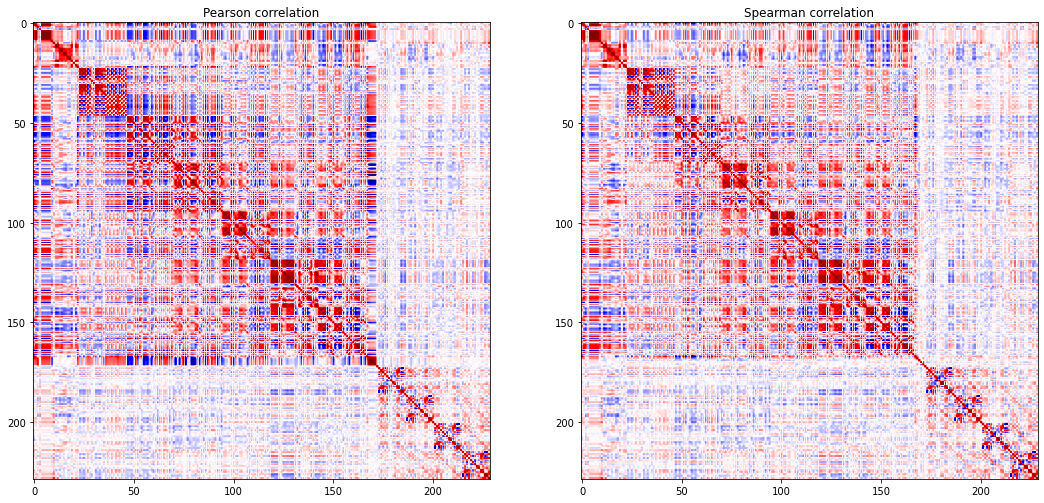

In [5]:
cmap = 'seismic'
vmax,vmin = 1,-1

fig, ax = plt.subplots(1,2,figsize=(18,9))

i = 0
ax[i].imshow(np.array(pcorr), cmap=cmap, vmax=vmax, vmin=vmin)
ax[i].set_title('Pearson correlation')

i = 1
ax[i].imshow(np.array(scorr), cmap=cmap, vmax=vmax, vmin=vmin)
ax[i].set_title('Spearman correlation');

In [201]:
for i,c in enumerate(scorr.columns):
    print(i, '\t', c)

0 	 canopy_cover
1 	 Weight
2 	 Moisture
3 	 Test.Weight
4 	 yield_originaal_moisture
5 	 yield_dry
6 	 yield_standard
7 	 yield_standard_bu
8 	 yield_dry_gm
9 	 dry_matter/plant(kg)
10 	 Ear_Leaf_Length (cm)
11 	 Ear_Leaf_Width (cm)
12 	 Ear_Leaf_Area (cm^2)
13 	 Ear_Height (cm)
14 	 Plant_Height (cm)
15 	 Ear_Leaf_N
16 	 Total_Leaf_N
17 	 AnthesisGDD
18 	 SilkingGDD
19 	 TLA (m2)
20 	 epd
21 	 ear_leaf_weight (g)
22 	 LAI
23 	 BLUE_2019702dronemean
24 	 BLUE_STD_2019702dronemean
25 	 GREEN_2019702dronemean
26 	 GREEN_STD_2019702dronemean
27 	 NDVI_2019702dronemean
28 	 NDVI_STD_2019702dronemean
29 	 NIR_2019702dronemean
30 	 NIR_STD_2019702dronemean
31 	 RED_2019702dronemean
32 	 RED_STD_2019702dronemean
33 	 RED_EDGE_2019702dronemean
34 	 RED_EDGE_STD_2019702dronemean
35 	 BGI_72_mean_2019702dronemean
36 	 BGI_72_STD_2019702dronemean
37 	 EVI_72_mean_2019702dronemean
38 	 EVI_72_STD_2019702dronemean
39 	 GNDVI_72_mean_2019702dronemean
40 	 GNDVI_72_STD_2019702dronemean
41 	 Ratio_72

In [6]:
#ss = list(range(23)) + list(range(167, len(scorr)))

ss = list(range(23)) + list(range(167, 178))

Text(0.5, 0.98, 'Spearman correlation')

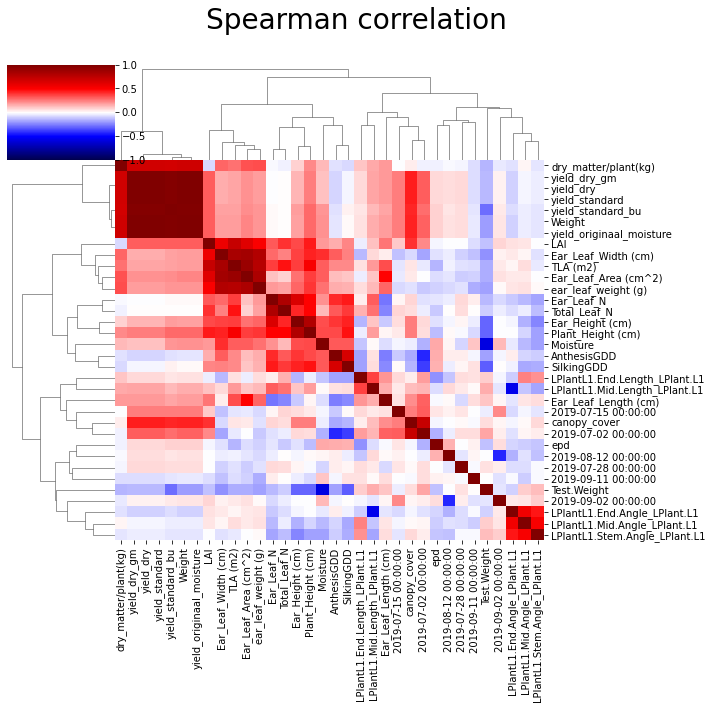

In [8]:
sns.clustermap(scorr.iloc[ss, ss], method='complete', vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Spearman correlation', fontsize=28)

#filename = dst + 'spearman_correlation_sub.jpg'
#plt.savefig(filename, dpi=130, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

Text(0.5, 0.98, 'Pearson correlation')

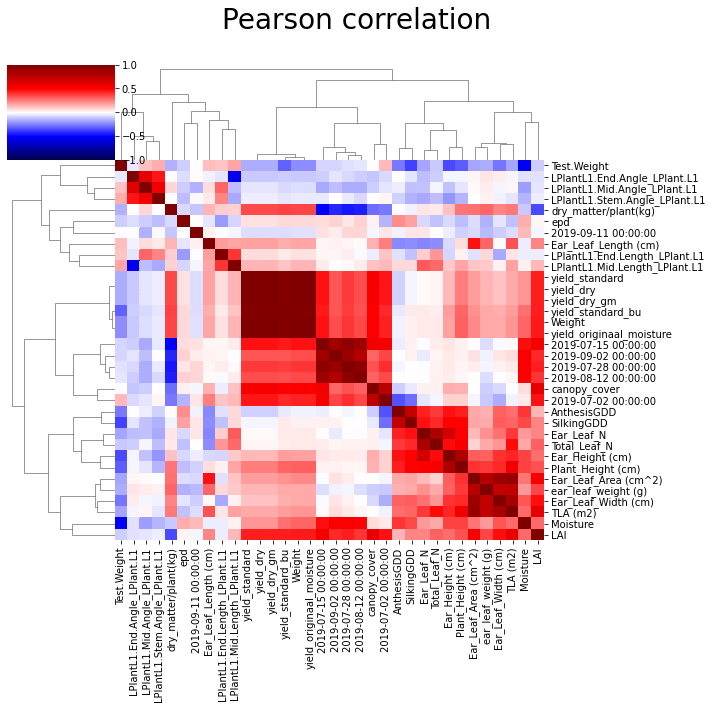

In [9]:
sns.clustermap(pcorr.iloc[ss,ss], method='complete', vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Pearson correlation', fontsize=28)

# Sklearn

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [12]:
cols = list(data.columns.values)
for i in range(len(cols)):
    print(i, '\t', cols[i])

0 	 plot
1 	 New_Source
2 	 New_Pedigree
3 	 Old_Pedigree
4 	 Old_Source
5 	 Shared
6 	 New_Family
7 	 Tester
8 	 Pass
9 	 Range
10 	 Group.1
11 	 Rep
12 	 Date.Time
13 	 Harvest.Sequence
14 	 Stand.Count
15 	 GreenSnap
16 	 Root Lodging
17 	 Stalk Lodging
18 	 canopy_cover
19 	 Weight
20 	 Moisture
21 	 Test.Weight
22 	 yield_originaal_moisture
23 	 yield_dry
24 	 yield_standard
25 	 yield_standard_bu
26 	 yield_dry_gm
27 	 dry_matter/plant(kg)
28 	 Ear_Leaf_Length (cm)
29 	 Ear_Leaf_Width (cm)
30 	 Ear_Leaf_Area (cm^2)
31 	 Ear_Height (cm)
32 	 Plant_Height (cm)
33 	 Ear_Leaf_N
34 	 Total_Leaf_N
35 	 AnthesisGDD
36 	 SilkingGDD
37 	 TLA (m2)
38 	 epd
39 	 ear_leaf_weight (g)
40 	 LAI
41 	 BLUE_2019702dronemean
42 	 BLUE_STD_2019702dronemean
43 	 GREEN_2019702dronemean
44 	 GREEN_STD_2019702dronemean
45 	 NDVI_2019702dronemean
46 	 NDVI_STD_2019702dronemean
47 	 NIR_2019702dronemean
48 	 NIR_STD_2019702dronemean
49 	 RED_2019702dronemean
50 	 RED_STD_2019702dronemean
51 	 RED_EDGE_201

In [32]:
colss = cols[14:16] + cols[19:41]
#colss += cols[191:196] + cols[205:210] + cols[219:224] + cols[233:238]
#colss += cols[196:205] + cols[210:219] + cols[224:233] + cols[238:]

pheno = data.loc[:, colss].copy()
pheno_scaled = StandardScaler().fit_transform(pheno)
pheno

,Stand.Count,GreenSnap,Weight,Moisture,Test.Weight,yield_originaal_moisture,yield_dry,yield_standard,yield_standard_bu,yield_dry_gm,...,Ear_Height (cm),Plant_Height (cm),Ear_Leaf_N,Total_Leaf_N,AnthesisGDD,SilkingGDD,TLA (m2),epd,ear_leaf_weight (g),LAI
0,90,0,27.17,24.1,56.3,10759.32,8166.32388,9664.288615,171.656991,773.277170,...,121.5,232.5,13.0,18.0,1150.25,1247.60,0.600025,64.150000,7.7,5.284322
1,82,1,24.95,22.8,57.9,9880.20,7627.51440,9026.644260,155.900592,722.256775,...,115.5,213.5,13.0,18.5,1174.60,1247.60,0.585252,76.621053,8.3,4.638798
2,76,0,25.71,23.9,58.0,10181.16,7747.86276,9169.068355,158.087385,733.652678,...,96.0,211.5,11.5,17.0,1150.25,1247.60,0.572554,70.062637,7.6,4.258021
3,70,0,24.46,24.5,55.1,9686.16,7313.05080,8654.497988,157.068929,692.479910,...,102.5,197.5,13.0,18.5,1150.25,1192.25,0.599842,76.980000,8.0,4.108775
4,61,0,22.25,23.1,57.1,8811.00,6775.65900,8018.531361,140.429621,641.593756,...,102.0,211.5,11.0,17.0,1192.25,1247.60,0.656643,70.062637,10.0,3.919551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,58,0,21.95,22.2,55.0,8692.20,6762.53160,8002.995976,145.509018,640.350710,...,95.5,199.5,11.0,16.5,1124.05,1209.45,0.492337,76.980000,8.0,2.794268
170,84,0,24.72,20.8,58.1,9789.12,7752.98304,9175.127858,157.919584,734.137523,...,89.0,184.5,12.0,18.0,1150.25,1247.60,0.435794,76.621053,5.1,3.582100
171,71,0,22.72,23.5,57.8,8997.12,6882.79680,8145.321657,140.922520,651.738739,...,105.5,202.0,11.0,16.0,1209.45,1247.60,0.543334,76.621053,7.8,3.774875
172,88,0,25.55,23.1,58.1,10117.80,7780.58820,9207.796686,158.481871,736.751482,...,114.5,223.0,12.5,18.5,1192.25,1293.55,0.560937,75.313158,7.4,4.830296


In [27]:
#y = data['canopy_cover'].values
y = data['2019-07-02 00:00:00'].values

y_scaled = (y - y.mean())/y.std()

In [15]:
svr = SVR(kernel='rbf', C=150, gamma=0.01, epsilon=.01)
#svr = SVR(kernel='poly', C=100, gamma=0.1, degree=3, epsilon=0.01, coef0=1)
#svr = SVR(kernel='linear', C=100, gamma=0.01)

In [16]:
ypred = svr.fit(pheno_scaled, y).predict(pheno_scaled)

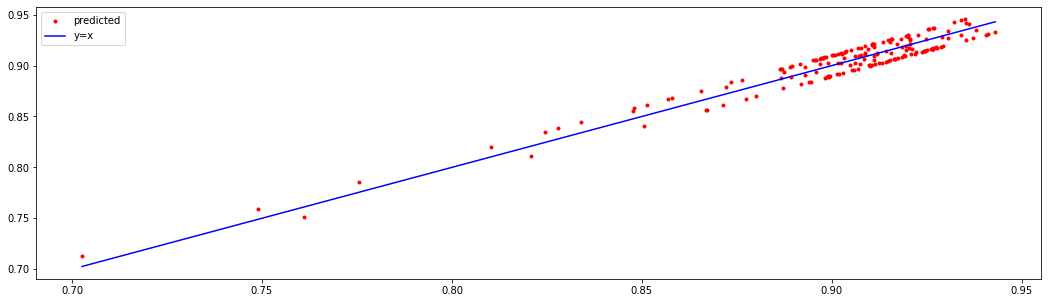

In [17]:
xaxis = np.linspace(np.min(y), np.max(y), 10)
plt.figure(figsize=(18,5))
plt.plot(y, ypred,'.r', label='predicted')
#plt.plot(ypred, '.b', label='predicted');
plt.plot(xaxis, xaxis, 'b', label='y=x')
plt.legend();

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pheno_scaled,
                                                    y,
                                                    test_size=0.25)

In [21]:
svr_params = {'C':10, 'kernel':'rbf', 'gamma':0.01, 'epsilon':.01}
#svr_params = {'C':100, 'kernel':'poly', 'gamma':'auto', 'epsilon':0.01, 'degree':3, 'coef0':1}
svr = SVR(**svr_params).fit(X_train, y_train)
print(svr.score(X_test, y_test))

0.4698127433420789


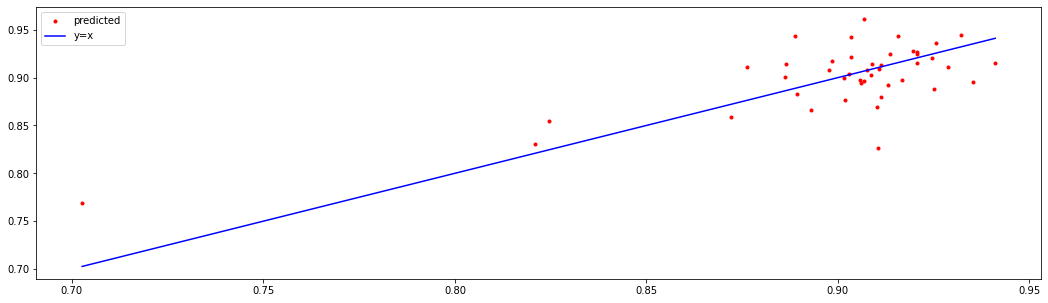

In [22]:
ypred = svr.predict(X_test)

xaxis = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.figure(figsize=(18,5))
plt.plot(y_test, ypred,'.r', label='predicted')
#plt.plot(ypred, '.b', label='predicted');
plt.plot(xaxis, xaxis, 'b', label='y=x')
plt.legend();

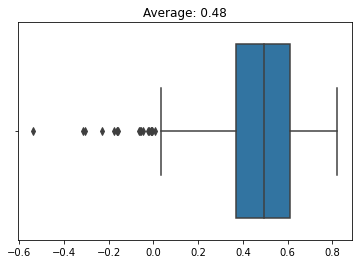

In [35]:
svr_params = {'C':50, 'kernel':'rbf', 'gamma':0.0009, 'epsilon':.01}
#svr_params = {'C':10, 'kernel':'poly', 'gamma':'auto', 'epsilon':0.01, 'degree':2, 'coef0':1}

N = 1000
score = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.2)
    svr = SVR(**svr_params).fit(X_train, y_train)
    score[i] = svr.score(X_test, y_test)
    
ax = sns.boxplot(x=score)
ax.set_title('Average: {:.2f}'.format(np.mean(score)));

### Using `y = canopy_cover` (scaled)

- polynomial kernels do not work for trad phenotypes
- 0.44 with radial kernel $\gamma = 0.01$
- 0.47 with $\gamma = 0.008$


- 0.37 with radial kernel $\gamma = 0.01$ for trad+ext phenotypes
- 0.47 with $\gamma = 0.001$
- 0.31 for poly 3
- 0.31 for poly 4


- 0.34 with radial kernel $\gamma = 0.01$ and trad+ext+model phenotypes
- 0.38 with radial kernel $\gamma = 0.005$
- 0.43 with radial kernel $\gamma = 0.002$
- 0.16 with poly kernel, deg 4
- 0.12 with poly kernel, deg 3

Watch out for very negative $R^2$ scores!

### Using `y = drone[190702]` (scaled)

- 0.38 with radial kernel $\gamma=0.01$ for trad phenotypes
- 0.36 with $\gamma=0.1$
- Polynomial kernels do not work


- 0.38 with radial kernel $\gamma=0.01$ for trad+ext phenotypes
- 0.30 for $\gamma=0.02$
- 0.37 for $\gamma=0.08$
- 0.20 for poly kernel deg 2, c0 = 1
- 0.29 for deg 3
- 0.32 for deg 4


- 0.39 with radial kernel $\gamma=0.008$ for trad+ext+model phenotypes
- 0.37 with $\gamma=0.01$
- 0.42 with $\gamma=0.002$
- 0.24 for poly kernel (deg 3, c0 = 3)
- 0.24 for poly kernel (deg 3, c0 = 1)
- 0.30 for deg 4
- 0.18 for deg 2
- 0.21 for deg 2, $\gamma=0.008$

### Using `y = canopy_cover` (unscaled)

- 0.15 with radial kernel and trad phenotypes
- This is down from 0.24 when the data set is expanded
- 0.24 actually achieved with $\gamma = 0.1$
- Pushed up to 0.30 with $\gamma = 0.05$
- poly kernel doesn't work


- 0.39 with radial kernel and trad+ext phenotypes ($\gamma = 0.005$)
- 0.35 with $\gamma = 0.01$
- poly kernel doesn't work


- 0.33 with radial kernel $\gamma=0.01$ and trad+ext+model phenotypes
- 0.24 with poly kernel, deg 3
- 0.16 with poly kernel, deg 2
- 0.25 with poly kernel, deg 4

Watch out for very negative $R^2$ scores!

### Using `y = drone[190702]` (unscaled)

- 0.41 with traditional phenotypes



- 0.17 with radial kernel and trad phenotyes ($\gamma=0.05$)
- Similar results with polynomial kernel


- Similar results with radial kernel for trad+ext phenotypes
- 0.24 for poly kernel (deg 3, c0 = 3)
- 0.29 for poly kernel (deg 3, c0 = 1)
- 0.32 for deg 4
- 0.36 for deg 2

# Ridge Regression

In [591]:
from sklearn.linear_model import Ridge

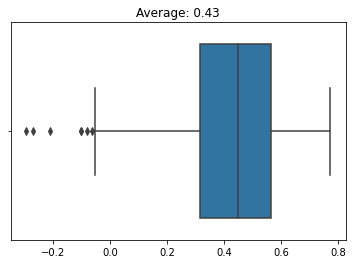

In [642]:
ridge_params = {'alpha':0.7, 'fit_intercept':False}

N = 1000
score = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(pheno_scaled, y_scaled, test_size=0.25)
    clf = Ridge(**ridge_params).fit(X_train, y_train)
    score[i] = clf.score(X_test, y_test)
    
ax = sns.boxplot(x=score)
ax.set_title('Average: {:.2f}'.format(np.mean(score)));

### `y = canopy_cover` (scaled)

- 0.29 with $\alpha=0.1$ for trad phenotypes
- 0.30 for $\alpha=0.01$
- 0.34 by setting `False` intercept fit


- 0.32 with $\alpha=0.5$ for trad+ext phenotypes


- 0.19 with $\alpha=1$ for trad+ext+model phenotypes

### `y = drone[190702]` (scaled)

- 0.50 with $\alpha = 0.75$ for trad phenotypes


- 0.43 with $\alpha = 0.43$ for trad+ext phenotypes


- 0.38 with $\alpha=1$ for trad+ext+model phenotypes

# PCA

In [643]:
y_var = (y - y.min())/(y.max() - y.min())

In [644]:
from sklearn.decomposition import PCA, KernelPCA

In [645]:
pca = PCA(n_components=2)
pca.fit(pheno_scaled)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.18671445 0.12415627]
[36.93926407 30.1219859 ]


In [646]:
prcomp = pca.transform(pheno_scaled)

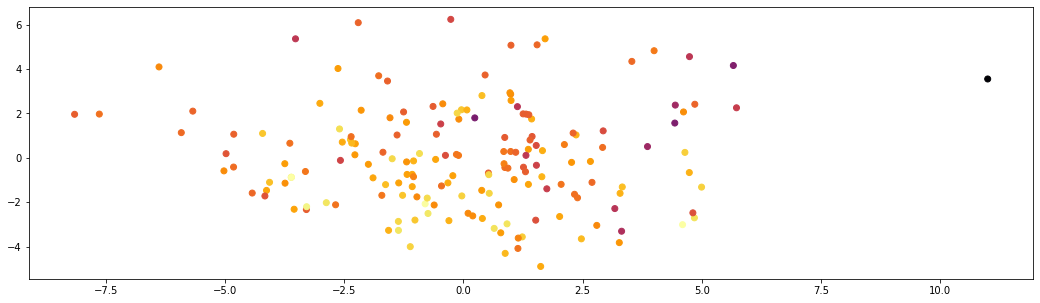

In [647]:
plt.figure(figsize=(18,5))

plt.scatter(prcomp[:,0], prcomp[:,1], c=y_var, cmap='inferno');

# KPCA

In [194]:
kpca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=False, gamma=0.3)
X_kpca = kpca.fit_transform(pheno_scaled)

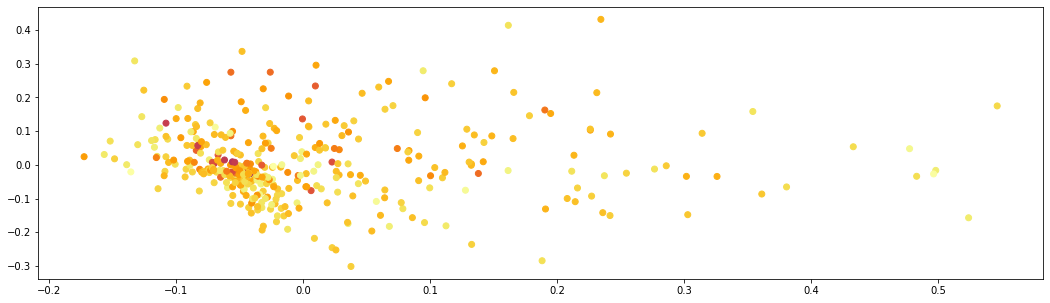

In [195]:
plt.figure(figsize=(18,5))

plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y_var, cmap='inferno');

In [ ]:
#